# Basic Tutorial for time-series modelling

In this tutorial we show, how to use the `timeseries_models` to fit noise observation from a vanderpol obsevration. First we will fit a simple Kalman-Filter model, and subsequently model with non-linear state transitions. We will see, that just two lines of code need to be changed to fir the more complicated model.

Of course, this is work-in-progress and suggestions for improvements are welcome.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from jax import config
config.update("jax_enable_x64", True)
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
np.random.seed(0)

## Data generation

First lets generate some data. We just generate 400 observations.

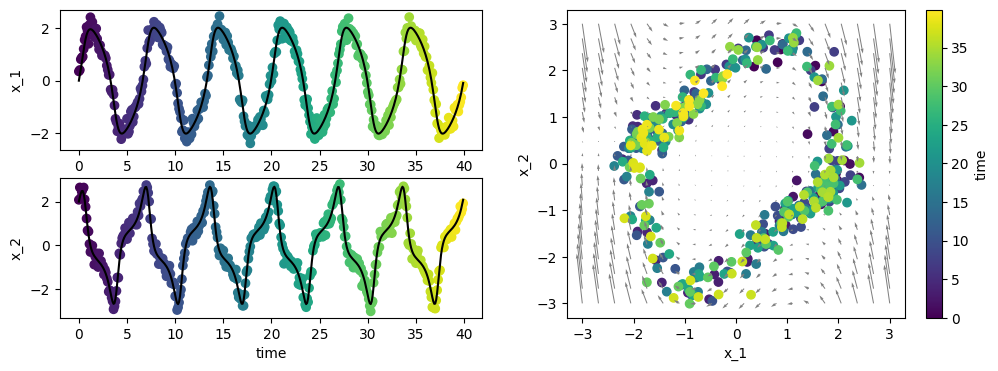

In [2]:

def vanderpol(x, t, mu=1.):
    x, y = x[..., 0], x[..., 1]
    return np.array([y, mu * (1 - x ** 2) * y - x])

x0 = np.array([0, 2.])
time = np.arange(0, 40, .1)
x_mu = odeint(vanderpol, x0, time)
x_data = x_mu + np.random.randn(*x_mu.shape) * .2
x_mesh = np.meshgrid(np.linspace(-3, 3, 20), np.linspace(-3, 3, 20))
x_mesh = np.stack([x_mesh[0].flatten(), x_mesh[1].flatten()], axis=-1)

dx_mesh = vanderpol(x_mesh, 0)

plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(time, x_mu[:, 0], 'k')
plt.scatter(time, x_data[:, 0], c=time)
plt.ylabel('x_1')
plt.subplot(2, 2, 3)
plt.plot(time, x_mu[:, 1], 'k')
plt.scatter(time, x_data[:, 1], c=time)
plt.ylabel('x_2')
plt.xlabel('time')
plt.subplot(1, 2, 2)
plt.scatter(x_data[:, 0], x_data[:, 1], c=time)
plt.colorbar(label='time')
plt.quiver(x_mesh[:, 0], x_mesh[:, 1], dx_mesh[0], dx_mesh[1], color='gray')
plt.ylabel('x_2')
plt.xlabel('x_1')
plt.show()

## Fitting the Kalman Filter

Now we compose our _state-space model_. A state-space model is always constructed of a _state model_, dictating the latent dynamics, and an _observation model_, which represents the mapping from latent to observation space. Both are assumed to be conditional Gaussians. 

For the _Kalman Filter_ the mean of state, and obsetvation model are linear, and hence we choose the linear model. We just need to specify the latent dimension `Dz`. Then we invoke the _expectation maximization_ algorithm, by the `fit` function.

In [6]:
from timeseries_models import state_model, observation_model, state_space_model

Dz = 2
Dx = x_data.shape[-1]

sm = state_model.LinearStateModel(Dz)
om = observation_model.LinearObservationModel(Dx, Dz, noise_x=.2)
ssm = state_space_model.StateSpaceModel(om, sm)
llk_list, p0_dict, smooth_dict, two_step_smooth_dict = ssm.fit(x_data)

Iteration 1 - Log likelihood=-255.6
Iteration 2 - Log likelihood=-157.6
Iteration 3 - Log likelihood=-120.0
Iteration 4 - Log likelihood=-104.4
Iteration 5 - Log likelihood=-96.5
Iteration 6 - Log likelihood=-91.0
Iteration 7 - Log likelihood=-86.4
Iteration 8 - Log likelihood=-82.3
Iteration 9 - Log likelihood=-78.7
Iteration 10 - Log likelihood=-75.4
Iteration 11 - Log likelihood=-72.4
Iteration 12 - Log likelihood=-69.8
Iteration 13 - Log likelihood=-67.5
Iteration 14 - Log likelihood=-65.3
Iteration 15 - Log likelihood=-63.4
Iteration 16 - Log likelihood=-61.7
Iteration 17 - Log likelihood=-60.2
Iteration 18 - Log likelihood=-58.8
Iteration 19 - Log likelihood=-57.5
Iteration 20 - Log likelihood=-56.3
Iteration 21 - Log likelihood=-55.2
Iteration 22 - Log likelihood=-54.3
Iteration 23 - Log likelihood=-53.4
Iteration 24 - Log likelihood=-52.5
Iteration 25 - Log likelihood=-51.8
Iteration 26 - Log likelihood=-51.0
Iteration 27 - Log likelihood=-50.4
Iteration 28 - Log likelihood=-49

## Making predictions

With the learnt model, we can make predictions. For this we need to invoke the `predict` function, which gives us the predictive density of the data.

TODO: At the moment one needs to provide an array with the length of `first_prediction_idx`+`prediction_steps`, which is a bit strange. Maybe this should be changed.

In [7]:
horizon = 1
prediction_steps = 400
x_prediction = np.vstack([x_data, np.zeros((prediction_steps, Dx))])
data_prediction_densities = ssm.predict(X=x_prediction, horizon=horizon, first_prediction_idx=x_data.shape[0]-1) 

With a bit more work we can also calculate the latent dynamics. 

TODO: This potentially should be automatized

Text(0.5, 1.0, 'Latent space')

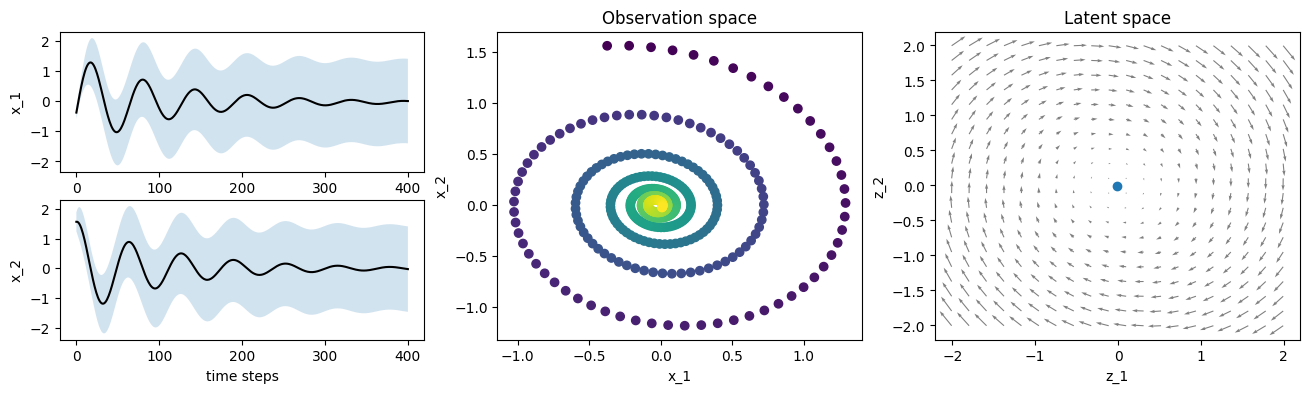

In [8]:
pred_time = np.arange(0, prediction_steps+1)
upper = data_prediction_densities.mu + np.sqrt(data_prediction_densities.Sigma.diagonal(axis1=-2, axis2=-1))
lower = data_prediction_densities.mu - np.sqrt(data_prediction_densities.Sigma.diagonal(axis1=-2, axis2=-1))

# Get the latent dynamics and it's fixed point
dz = lambda z: ssm.sm.state_density.get_conditional_mu(z[None])[0,0] - z
fp = fsolve(dz, np.zeros((2)))
z_mesh = np.meshgrid(np.linspace(fp[0] - 2, fp[0] + 2.,20), np.linspace(fp[1]-2.,fp[1]+2.,20))
z_mesh = np.stack([z_mesh[0].flatten(), z_mesh[1].flatten()], axis=-1)
dz_pred = np.vstack([dz(z) for z in z_mesh])

# Plotting
plt.figure(figsize=(16, 4))
plt.subplot(2, 3, 1)
plt.plot(data_prediction_densities.mu[:, 0], 'k')
plt.fill_between(np.arange(data_prediction_densities.mu.shape[0]), upper[:, 0], lower[:, 0], alpha=.2)
plt.ylabel('x_1')
plt.subplot(2, 3, 4)
plt.plot(data_prediction_densities.mu[:, 1], 'k')
plt.fill_between(np.arange(data_prediction_densities.mu.shape[0]), upper[:, 1], lower[:, 1], alpha=.2)
plt.xlabel('time steps')
plt.ylabel('x_2')
plt.subplot(1, 3, 2)
plt.scatter(data_prediction_densities.mu[:, 0], data_prediction_densities.mu[:, 1], c=pred_time)
plt.title('Observation space')
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.subplot(1, 3, 3)
plt.quiver(z_mesh[:, 0], z_mesh[:, 1], dz_pred[:, 0], dz_pred[:, 1], color='gray')
plt.scatter(fp[0], fp[1], c='C0')
plt.xlabel('z_1')
plt.ylabel('z_2')
plt.title('Latent space')

We see, that the dynamics cannot be well represented by this linear model. This is because a linear model cannot represent a limit-cycle (TODO: Check that this is true). Hence, let's consider a more complicated model.

## Fitting the non-linear Kalman Filter

For fitting the non-linear Kalman-Filter, we just need to exchange the state-model. Here we choose a model, whose conditional Gaussian has a non-linear kernel part (number of kernels `Dk`) in addition to the linear part. The fitting takes a bit longer because, not all parameters in the M-step of the EM algorithm have analytical updates, and we resort to numerical optimizations.

In [3]:
from timeseries_models import state_model, observation_model, state_space_model

Dz = 2
Dk = 5
Dx = x_data.shape[-1]

sm = state_model.LSEMStateModel(Dz, Dk)
om = observation_model.LinearObservationModel(Dx, Dz)
ssm = state_space_model.StateSpaceModel(om, sm)
llk_list, p0_dict, smooth_dict, two_step_smooth_dict = ssm.fit(x_data)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Iteration 1 - Log likelihood=-914.5
Iteration 2 - Log likelihood=-624.7
Iteration 3 - Log likelihood=-400.7
Iteration 4 - Log likelihood=-227.7
Iteration 5 - Log likelihood=-105.9
Iteration 6 - Log likelihood=-31.7
Iteration 7 - Log likelihood=7.8
Iteration 8 - Log likelihood=27.6
Iteration 9 - Log likelihood=38.6
Iteration 10 - Log likelihood=46.2
Iteration 11 - Log likelihood=52.3
Iteration 12 - Log likelihood=57.6
Iteration 13 - Log likelihood=62.3
Iteration 14 - Log likelihood=66.5
Iteration 15 - Log likelihood=70.3
Iteration 16 - Log likelihood=73.8
Iteration 17 - Log likelihood=77.0
Iteration 18 - Log likelihood=79.9
Iteration 19 - Log likelihood=82.6
Iteration 20 - Log likelihood=85.1
Iteration 21 - Log likelihood=87.5
Iteration 22 - Log likelihood=89.7
Iteration 23 - Log likelihood=91.8
Iteration 24 - Log likelihood=93.8
Iteration 25 - Log likelihood=95.7
Iteration 26 - Log likelihood=97.5
Iteration 27 - Log likelihood=99.2
Iteration 28 - Log likelihood=100.8
Iteration 29 - Log

## Prediction

Prediction and calculation of the dynamics are exactly done as before.

In [4]:
horizon = 1
prediction_steps = 400
x_prediction = np.vstack([x_data, np.zeros((prediction_steps, Dx))])
data_prediction_densities = ssm.predict(X=x_prediction, horizon=horizon, first_prediction_idx=x_data.shape[0]-1) 

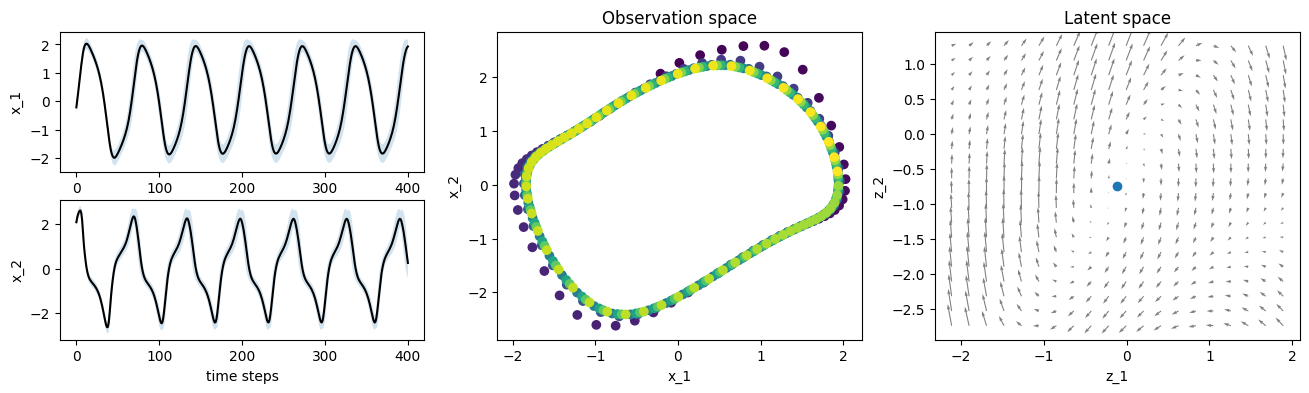

In [5]:
pred_time = np.arange(0, prediction_steps+1)
upper = data_prediction_densities.mu + np.sqrt(data_prediction_densities.Sigma.diagonal(axis1=-2, axis2=-1))
lower = data_prediction_densities.mu - np.sqrt(data_prediction_densities.Sigma.diagonal(axis1=-2, axis2=-1))

dz = lambda z: ssm.sm.state_density.get_conditional_mu(z[None])[0] - z
fp = fsolve(dz, np.zeros((1,2)))
z_mesh = np.meshgrid(np.linspace(fp[0] - 2., fp[0] + 2.,20), np.linspace(fp[1]-2.,fp[1]+2.,20))
z_mesh = np.stack([z_mesh[0].flatten(), z_mesh[1].flatten()], axis=-1)
dz_pred = np.vstack([dz(z) for z in z_mesh])

plt.figure(figsize=(16, 4))
plt.subplot(2, 3, 1)
plt.plot(data_prediction_densities.mu[:, 0], 'k')
plt.fill_between(np.arange(data_prediction_densities.mu.shape[0]), upper[:, 0], lower[:, 0], alpha=.2)
plt.ylabel('x_1')
plt.subplot(2, 3, 4)
plt.plot(data_prediction_densities.mu[:, 1], 'k')
plt.fill_between(np.arange(data_prediction_densities.mu.shape[0]), upper[:, 1], lower[:, 1], alpha=.2)
plt.xlabel('time steps')
plt.ylabel('x_2')
plt.subplot(1, 3, 2)
plt.scatter(data_prediction_densities.mu[:, 0], data_prediction_densities.mu[:, 1], c=pred_time)
plt.title('Observation space')
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.subplot(1, 3, 3)
plt.quiver(z_mesh[:, 0], z_mesh[:, 1], dz_pred[:, 0], dz_pred[:, 1], color='gray')
plt.scatter(fp[0], fp[1], c='C0')
plt.xlabel('z_1')
plt.ylabel('z_2')
plt.title('Latent space')
plt.show()

We see, that now the dynamics could be learnt very well, and the dynamics provide a nice limit cycle.

TODO: Can we get the dynamics in the observation space as well?
TODO: Maybe return also the density in the latent space?

## Fitting the non-linear observation model

Now we consider a non-linear observation-model. Here we choose a model, whose conditional Gaussian has a non-linear kernel part (number of kernels `Dk`) in addition to the linear part. 

In [7]:
from timeseries_models import state_model, observation_model, state_space_model

Dz = 2
Dk = 5
Dx = x_data.shape[-1]

sm = state_model.LinearStateModel(Dz)
om = observation_model.LSEMObservationModel(Dx, Dz, Dk)
ssm = state_space_model.StateSpaceModel(om, sm)
llk_list, p0_dict, smooth_dict, two_step_smooth_dict = ssm.fit(x_data)


Iteration 1 - Log likelihood=-895.0
Iteration 2 - Log likelihood=-511.0
Iteration 3 - Log likelihood=-285.7
Iteration 4 - Log likelihood=-160.5
Iteration 5 - Log likelihood=-92.1
Iteration 6 - Log likelihood=-56.2
Iteration 7 - Log likelihood=-36.4
Iteration 8 - Log likelihood=-23.9
Iteration 9 - Log likelihood=-14.8
Iteration 10 - Log likelihood=-7.5
Iteration 11 - Log likelihood=-1.2
Iteration 12 - Log likelihood=4.4
Iteration 13 - Log likelihood=9.6
Iteration 14 - Log likelihood=14.5
Iteration 15 - Log likelihood=19.3
Iteration 16 - Log likelihood=24.2
Iteration 17 - Log likelihood=29.2
Iteration 18 - Log likelihood=34.5
Iteration 19 - Log likelihood=40.1
Iteration 20 - Log likelihood=46.0
Iteration 21 - Log likelihood=52.3
Iteration 22 - Log likelihood=58.6
Iteration 23 - Log likelihood=65.0
Iteration 24 - Log likelihood=71.0
Iteration 25 - Log likelihood=76.4
Iteration 26 - Log likelihood=81.2
Iteration 27 - Log likelihood=85.3
Iteration 28 - Log likelihood=88.7
Iteration 29 - Log

## Prediction

And Once again we make predictions with the fitted model.

In [8]:
horizon = 1
prediction_steps = 400
x_prediction = np.vstack([x_data, np.zeros((prediction_steps, Dx))])
data_prediction_densities = ssm.predict(X=x_prediction, horizon=horizon, first_prediction_idx=x_data.shape[0]-1) 

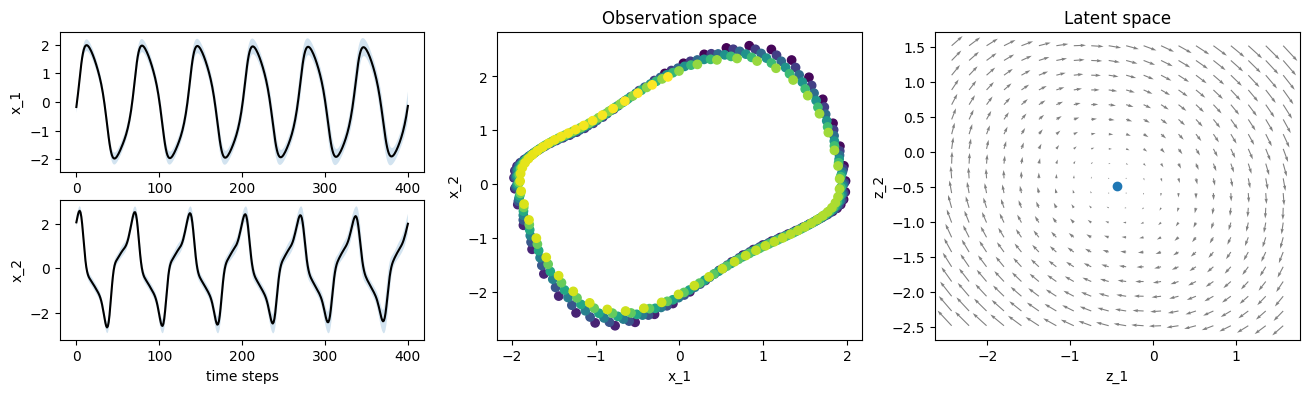

In [15]:
pred_time = np.arange(0, prediction_steps+1)
upper = data_prediction_densities.mu + np.sqrt(data_prediction_densities.Sigma.diagonal(axis1=-2, axis2=-1))
lower = data_prediction_densities.mu - np.sqrt(data_prediction_densities.Sigma.diagonal(axis1=-2, axis2=-1))

dz = lambda z: ssm.sm.state_density.get_conditional_mu(z[None])[0,0] - z
fp = fsolve(dz, np.zeros((1,2)))
z_mesh = np.meshgrid(np.linspace(fp[0] - 2., fp[0] + 2.,20), np.linspace(fp[1]-2.,fp[1]+2.,20))
z_mesh = np.stack([z_mesh[0].flatten(), z_mesh[1].flatten()], axis=-1)
dz_pred = np.vstack([dz(z) for z in z_mesh])

plt.figure(figsize=(16, 4))
plt.subplot(2, 3, 1)
plt.plot(data_prediction_densities.mu[:, 0], 'k')
plt.fill_between(np.arange(data_prediction_densities.mu.shape[0]), upper[:, 0], lower[:, 0], alpha=.2)
plt.ylabel('x_1')
plt.subplot(2, 3, 4)
plt.plot(data_prediction_densities.mu[:, 1], 'k')
plt.fill_between(np.arange(data_prediction_densities.mu.shape[0]), upper[:, 1], lower[:, 1], alpha=.2)
plt.xlabel('time steps')
plt.ylabel('x_2')
plt.subplot(1, 3, 2)
plt.scatter(data_prediction_densities.mu[:, 0], data_prediction_densities.mu[:, 1], c=pred_time)
plt.title('Observation space')
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.subplot(1, 3, 3)
plt.quiver(z_mesh[:, 0], z_mesh[:, 1], dz_pred[:, 0], dz_pred[:, 1], color='gray')
plt.scatter(fp[0], fp[1], c='C0')
plt.xlabel('z_1')
plt.ylabel('z_2')
plt.title('Latent space')
plt.show()

## Features not covered by this tutorial

- Multiple time-series
- Heteroscedastic models (still in development)
- Control models (Also not tested thoroughly)